In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
header = ["address", "type", "price", "bedrooms", "bathrooms", "lat", "long", "hydro", "heat", "water", "laundry", "backyard", "parking", "gym", "sqft", "funished", "A/C", "walkscore", "transitscore", "bikescore", "bathroomscore", "bedroomscore", "kitchenscore"]
df = pd.read_csv("/content/gdrive/My Drive/folder/Colab Notebooks/proj_man.csv",names=header,index_col=False)
df[:3]

,address,type,price,bedrooms,bathrooms,lat,long,hydro,heat,water,laundry,backyard,parking,gym,sqft,funished,A/C,walkscore,transitscore,bikescore,bathroomscore,bedroomscore,kitchenscore
0,1 Bloor St,apartment,3500,2.0,2,43.67027,-79.394350,0,1,1,0,0,0,0,800,1,0,96,97,98,50,60,80
1,1 St George St,apartment,1750,0.0,1,43.66454,-79.385590,0,0,0,0,0,0,0,300,1,0,99,93,96,80,20,30
2,1 Steeles St,basement,2100,2.0,1,43.64954,-79.433937,1,1,1,0,0,0,0,800,1,0,88,85,69,44,45,54


In [ ]:
# filtering out not needed columns
subdf = df[["type", "price", "bedrooms", "bathrooms", "lat", "long", "hydro", "heat", "water", "laundry", "backyard", "parking", "gym", "sqft", "funished", "A/C", "walkscore", "transitscore", "bikescore", "bathroomscore", "bedroomscore", "kitchenscore"]]
subdf[:3]

,type,price,bedrooms,bathrooms,lat,long,hydro,heat,water,laundry,backyard,parking,gym,sqft,funished,A/C,walkscore,transitscore,bikescore,bathroomscore,bedroomscore,kitchenscore
0,apartment,3500,2.0,2,43.67027,-79.394350,0,1,1,0,0,0,0,800,1,0,96,97,98,50,60,80
1,apartment,1750,0.0,1,43.66454,-79.385590,0,0,0,0,0,0,0,300,1,0,99,93,96,80,20,30
2,basement,2100,2.0,1,43.64954,-79.433937,1,1,1,0,0,0,0,800,1,0,88,85,69,44,45,54


In [ ]:
# one hot unit_type
print(set(subdf["type"]))
data = pd.get_dummies(subdf)
data

{'apartment', 'basement'}


,price,bedrooms,bathrooms,lat,long,hydro,heat,water,laundry,backyard,parking,gym,sqft,funished,A/C,walkscore,transitscore,bikescore,bathroomscore,bedroomscore,kitchenscore,type_apartment,type_basement
0,3500,2.0,2,43.67027,-79.394350,0,1,1,0,0,0,0,800,1,0,96,97,98,50,60,80,1,0
1,1750,0.0,1,43.66454,-79.385590,0,0,0,0,0,0,0,300,1,0,99,93,96,80,20,30,1,0
2,2100,2.0,1,43.64954,-79.433937,1,1,1,0,0,0,0,800,1,0,88,85,69,44,45,54,0,1
3,2299,2.0,2,43.68094,-79.450180,0,1,1,0,0,0,0,900,1,0,39,75,55,12,12,32,0,1
4,2100,1.5,1,43.66298,-79.463230,0,1,1,0,0,0,0,700,1,0,94,85,77,90,90,90,1,0


In [ ]:
datanp = data.values.astype(np.float32) # pandas dataframe -> numpy 

# split data 70, 15, 15
np.random.seed(50)
np.random.shuffle(datanp)
train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

print(train_set.shape[0], val_set.shape[0], test_set.shape[0])

3 1 1


In [ ]:
all_columns = ["type", "price", "bedrooms", "bathrooms", "lat", "long", "hydro", "heat", "water", "laundry", "backyard", "parking", "gym", "sqft", "funished", "A/C", "walkscore", "transitscore", "bikescore", "bathroomscore", "bedroomscore", "kitchenscore"]
all_index = {}  # Mapping of feature -> start index of feature in a record
all_values = {} # Mapping of feature -> list of categorical values the feature can take

for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split('_')
        if feature not in all_index:
            all_index[feature] = i
            all_values[feature] = [value]
        else:
            all_values[feature].append(value)
    else:
      all_index[header] = i
      all_values[header] = ["non-categorical"]
print(all_index, all_values)

def get_onehot(record, feature):
    start_index = all_index[feature]
    stop_index = all_index[feature] + len(all_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    return all_values[feature][np.argmax(onehot)]


def get_feature(record, feature):
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    return { f: get_feature(record, f) for f in all_columns }

{'price': 0, 'bedrooms': 1, 'bathrooms': 2, 'lat': 3, 'long': 4, 'hydro': 5, 'heat': 6, 'water': 7, 'laundry': 8, 'backyard': 9, 'parking': 10, 'gym': 11, 'sqft': 12, 'funished': 13, 'A/C': 14, 'walkscore': 15, 'transitscore': 16, 'bikescore': 17, 'bathroomscore': 18, 'bedroomscore': 19, 'kitchenscore': 20, 'type': 21} {'price': ['non-categorical'], 'bedrooms': ['non-categorical'], 'bathrooms': ['non-categorical'], 'lat': ['non-categorical'], 'long': ['non-categorical'], 'hydro': ['non-categorical'], 'heat': ['non-categorical'], 'water': ['non-categorical'], 'laundry': ['non-categorical'], 'backyard': ['non-categorical'], 'parking': ['non-categorical'], 'gym': ['non-categorical'], 'sqft': ['non-categorical'], 'funished': ['non-categorical'], 'A/C': ['non-categorical'], 'walkscore': ['non-categorical'], 'transitscore': ['non-categorical'], 'bikescore': ['non-categorical'], 'bathroomscore': ['non-categorical'], 'bedroomscore': ['non-categorical'], 'kitchenscore': ['non-categorical'], 'ty

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "large"
        self.encoder = nn.Sequential(
            nn.Linear(23, 50),
            nn.Linear(50, 40)
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 50), 
            nn.Linear(50, 23),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, batch_size=64):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, iterations, losses = [], [], [], []
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) 
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1

        iterations.append(n)
        losses.append(float(loss)/batch_size)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        model_path = model.name + str(batch_size) + str(learning_rate) + str(epoch)
        #print(model_path)
        torch.save(model.state_dict(), model_path)
        print("Epoch: ", epoch, "Training Accuracy: ", get_accuracy(model, train_loader), "Validation Accuracy: ", get_accuracy(model, valid_loader))

    return train_acc, val_acc, iterations, losses

def zero_out_feature(records, feature):
    start_index = all_index[feature]
    stop_index = all_index[feature] + len(all_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    return zero_out_feature(records, random.choice(all_columns))




def get_accuracy(model, data_loader):
    total = 0
    acc = 0
    for col in all_columns:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                print(out.shape, col, out[i][all_index[col]], inp[i][all_index[col]], int(get_feature(out[i], col) == get_feature(inp[i], col)))
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total


(3, 23) type 4.3283685e-38 0.0 0
(3, 23) type 1.2397224e-34 0.0 0
(3, 23) type 9.625839e-28 1.0 0
(3, 23) price 1.8352789e-12 2299.0 1
(3, 23) price 2.1237553e-10 2100.0 1
(3, 23) price 0.0016705124 1750.0 1
(3, 23) bedrooms 2.2046284e-05 2.0 1
(3, 23) bedrooms 9.413631e-06 2.0 1
(3, 23) bedrooms 4.392685e-05 0.0 1
(3, 23) bathrooms 2.244217e-16 2.0 1
(3, 23) bathrooms 2.1574604e-16 1.0 1
(3, 23) bathrooms 4.682476e-15 1.0 1
(3, 23) lat 3.0506382e-11 43.68094 1
(3, 23) lat 8.949551e-10 43.64954 1
(3, 23) lat 1.0419039e-08 43.66454 1
(3, 23) long 0.98228514 -79.45018 1
(3, 23) long 0.9497646 -79.43394 1
(3, 23) long 0.017595123 -79.38559 1
(3, 23) hydro 1.0 0.0 1
(3, 23) hydro 1.0 1.0 1
(3, 23) hydro 1.0 0.0 1
(3, 23) heat 1.7264734e-24 1.0 1
(3, 23) heat 9.792385e-22 1.0 1
(3, 23) heat 8.036724e-17 0.0 1
(3, 23) water 2.805304e-10 1.0 1
(3, 23) water 1.385373e-08 1.0 1
(3, 23) water 0.00039519244 0.0 1
(3, 23) laundry 1.0 0.0 1
(3, 23) laundry 1.0 0.0 1
(3, 23) laundry 1.0 0.0 1
(3, 23

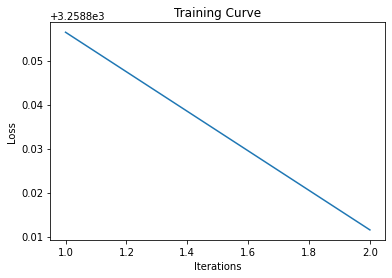

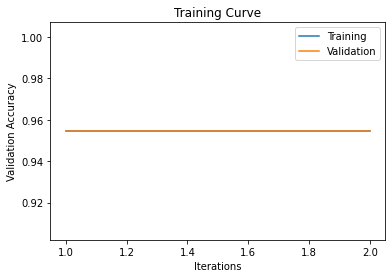

In [ ]:
import matplotlib.pyplot as plt

train_loader = torch.utils.data.DataLoader(train_set, batch_size=5, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=5, num_workers=1)
autoencoder = AutoEncoder()
t_acc, v_acc, iters_acc, loss = train(autoencoder, train_loader, val_loader, num_epochs=2, learning_rate=.0001)

plt.title("Training Curve")
plt.plot(iters_acc, loss, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(iters_acc, t_acc, label="Training")
plt.plot(iters_acc, v_acc, label="Validation")    
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
# test
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=1)
autoencoder = AutoEncoder()
train(autoencoder, train_loader, test_loader, num_epochs=30, learning_rate=.001)

Streaming output truncated to the last 5000 lines.
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
Epoch:  1 Training Accuracy:  0.9696969696969697 Validation Accuracy:  1.0
apartment basement
apartment basement
apartment apartment
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical non-categorical
non-categorical 

([0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697,
  0.9696969696969697],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,